
BioIB application in the single-cell dataset of NFT-free and NFT-bearing neurons

(Data from https://www.sciencedirect.com/science/article/pii/S0896627322006006?via%3Dihub)

0. Imports

In [1]:
from bioib import bioib, utils, plotting

In [2]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import anndata as ad
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [4]:
adata=sc.read_h5ad('AD_excitatory_tau_Neuron2022.h5ad')
adata.layers["counts"] = adata.raw.X.copy()
subtype='Ex02_CUX2-COL5A2 (L2-L4)'
adata_subtype=adata[adata.obs['Cell.Types']==subtype]
adata_subtype=adata_subtype[adata_subtype.obs['SORT'].isin(['AT8', 'MAP2'])]


In [5]:
new_labels=[]
for l in adata_subtype.obs['SORT']:
    if l =='AT8':
        new_labels.append('NFT-bearing')
    elif l =='MAP2':
        new_labels.append('NFT-free')
adata_subtype.obs['NFT status']=new_labels


In [6]:
adata_subtype.var_names_make_unique()
sc.pp.normalize_per_cell(adata_subtype, counts_per_cell_after=1e4)
sc.pp.log1p(adata_subtype)
n_hvg = 3000
sc.pp.highly_variable_genes(adata_subtype, n_top_genes=n_hvg)
adata_hvg = adata_subtype[:, adata_subtype.var["highly_variable"]]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [7]:
import mygene
ensembl_ids = list(adata_hvg.var_names)
mg = mygene.MyGeneInfo()
results = mg.querymany(ensembl_ids, scopes='ensembl.gene', fields='symbol', species='human')
id_to_symbol = {res['query']: res.get('symbol', res['query']) for res in results}
print(id_to_symbol)
new_var_names=[id_to_symbol[i] for i in adata_hvg.var_names]
adata_hvg.var_names=new_var_names
adata_hvg.var_names_make_unique()
adata=adata_hvg.copy()

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
2 input query terms found dup hits:	[('ENSG00000257545', 2), ('ENSG00000243620', 2)]
49 input query terms found no hit:	['ENSG00000236262', 'ENSG00000250060', 'ENSG00000271156', 'ENSG00000266002', 'ENSG00000278626', 'ENS


{'ENSG00000263438': 'LINC01919', 'ENSG00000072657': 'TRHDE', 'ENSG00000102225': 'CDK16', 'ENSG00000144671': 'SLC22A14', 'ENSG00000236262': 'ENSG00000236262', 'ENSG00000163930': 'BAP1', 'ENSG00000273204': 'ENSG00000273204', 'ENSG00000091138': 'SLC26A3', 'ENSG00000007376': 'RPUSD1', 'ENSG00000282885': 'ENSG00000282885', 'ENSG00000176919': 'C8G', 'ENSG00000167508': 'MVD', 'ENSG00000256813': 'CCDC86-AS1', 'ENSG00000250060': 'ENSG00000250060', 'ENSG00000176956': 'LY6H', 'ENSG00000226308': 'LOC112268270', 'ENSG00000139636': 'LMBR1L', 'ENSG00000228613': 'ENSG00000228613', 'ENSG00000196090': 'PTPRT', 'ENSG00000126746': 'ZNF384', 'ENSG00000140937': 'CDH11', 'ENSG00000271156': 'ENSG00000271156', 'ENSG00000269635': 'ENSG00000269635', 'ENSG00000131050': 'BPIFA2', 'ENSG00000167393': 'PPP2R3B', 'ENSG00000171189': 'GRIK1', 'ENSG00000182795': 'C1orf116', 'ENSG00000141985': 'SH3GL1', 'ENSG00000260927': 'ENSG00000260927', 'ENSG00000237480': 'ENSG00000237480', 'ENSG00000272568': 'CPVL-AS2', 'ENSG00000136

In [8]:
signal_of_interest='NFT status'
groups_of_interest=['NFT-bearing', 'NFT-free']

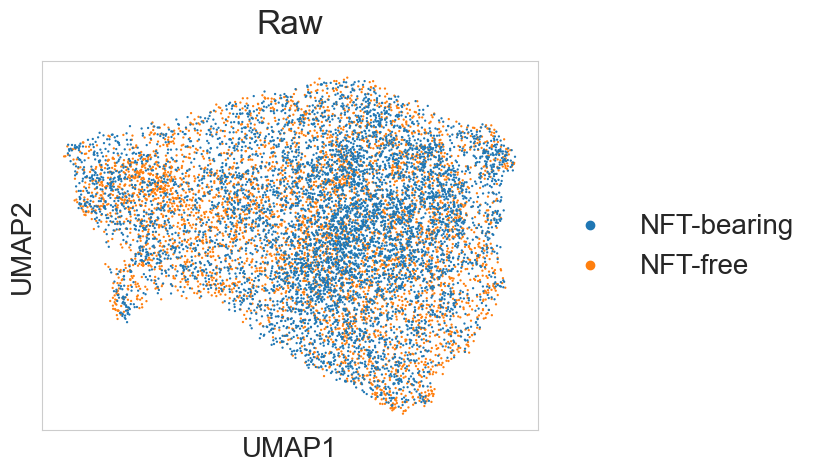

In [10]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
with plt.rc_context():
    sc.pl.umap(adata, color=signal_of_interest, show=False)
    plt.title('Raw', pad=20)
    plt.show()

In [9]:
n_metagenes=2

bioib_sort = bioib.bioIB(
    adata=adata,
    signal_of_interest=signal_of_interest,
    groups_of_interest=groups_of_interest,
    bulk=True,
    copy=True)
adata = bioib_sort.flat_clustering(n_metagenes)

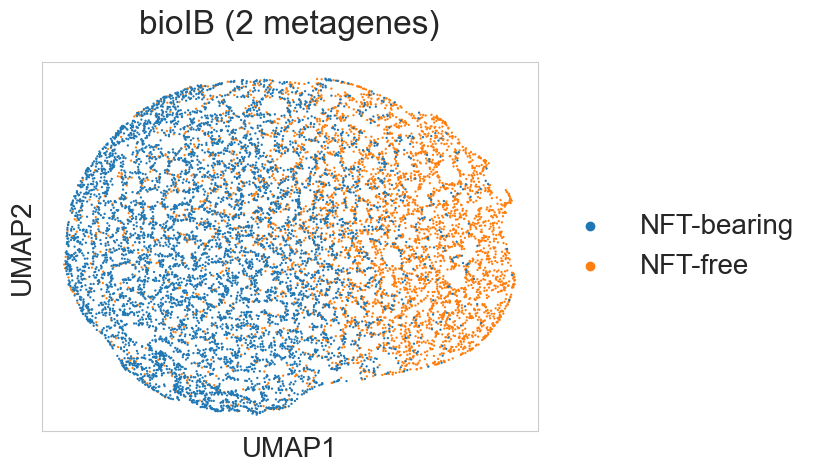

In [10]:
sc.pp.neighbors(adata, use_rep='bioIB_compressed_data_flat_%s_MGs' % n_metagenes)
sc.tl.umap(adata)
with plt.rc_context():
    sc.pl.umap(adata, color=signal_of_interest, show=False)
    plt.title('bioIB (%s metagenes)' % n_metagenes, pad=20)
    plt.show()

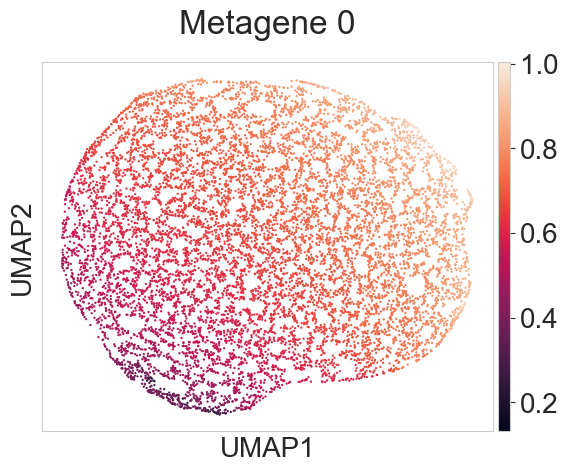

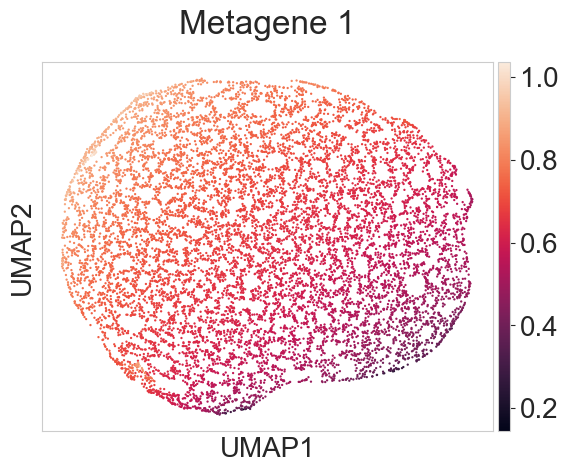

In [13]:
for mg in range(n_metagenes):
    with plt.rc_context():
        sc.pl.umap(adata, color='Metagene %s' % mg, show=False)
        plt.title('Metagene %s' % mg, pad=20)
        plt.show()

In [15]:
gene_to_metagene = adata.uns["bioIB_flat_%s_MGs_gene_to_MG" % n_metagenes]  #np.array
gene_to_metagene_df = pd.DataFrame(gene_to_metagene, index=list(adata.var_names), columns=['MG %s' % i for i in range(n_metagenes)])
gene_to_metagene_df.head(10)

,MG 0,MG 1
LINC01919,0.000000e+00,9.545637e-07
TRHDE,5.499303e-03,2.070464e-95
CDK16,3.134852e-12,1.068200e-03
SLC22A14,4.870969e-04,2.256573e-50
ENSG00000236262,0.000000e+00,1.765714e-06
BAP1,1.280972e-121,8.507776e-04
ENSG00000273204,5.163902e-106,4.108049e-05
SLC26A3,7.250323e-08,5.786728e-03
RPUSD1,1.369539e-163,3.922249e-04
ENSG00000282885,1.353144e-04,2.466360e-88


In [16]:
cell_to_metagene = adata.uns['bioIB_flat_%s_MGs_group_of_interest_to_MG' % n_metagenes]
cell_to_metagene_df = pd.DataFrame(cell_to_metagene, index=groups_of_interest, columns=['MG %s' % i for i in range(n_metagenes)])
cell_to_metagene_df.head()

,MG 0,MG 1
NFT-bearing,0.45179,0.539995
NFT-free,0.54821,0.460005


In [17]:
compressed_data = adata.obsm['bioIB_compressed_data_flat_%s_MGs' % n_metagenes]
compressed_data_df=pd.DataFrame(compressed_data, index=list(adata.obs_names), columns=['MG %s' % i for i in range(n_metagenes)])
compressed_data_df.head(10)


,MG 0,MG 1
C0001_AAACGGGAGTGCCATT-1,0.741780,0.733538
C0001_AAACGGGCATATACGC-1,0.742087,0.736343
C0001_AAAGCAAGTCAATACC-1,0.793457,0.771603
C0001_AAATGCCAGTTCGCAT-1,0.744227,0.606662
C0001_AAATGCCGTCTAGAGG-1,0.649167,0.795122
C0001_AACCGCGGTTCCAACA-1,0.756072,0.768405
C0001_AACTCAGGTACGACCC-1,0.543177,0.771646
C0001_AACTCCCTCGAATCCA-1,0.806588,0.499080
C0001_AACTCTTTCTTGCCGT-1,0.753004,0.455657
C0001_AACTTTCAGGATGTAT-1,0.750127,0.683610


<Figure size 800x1200 with 0 Axes>

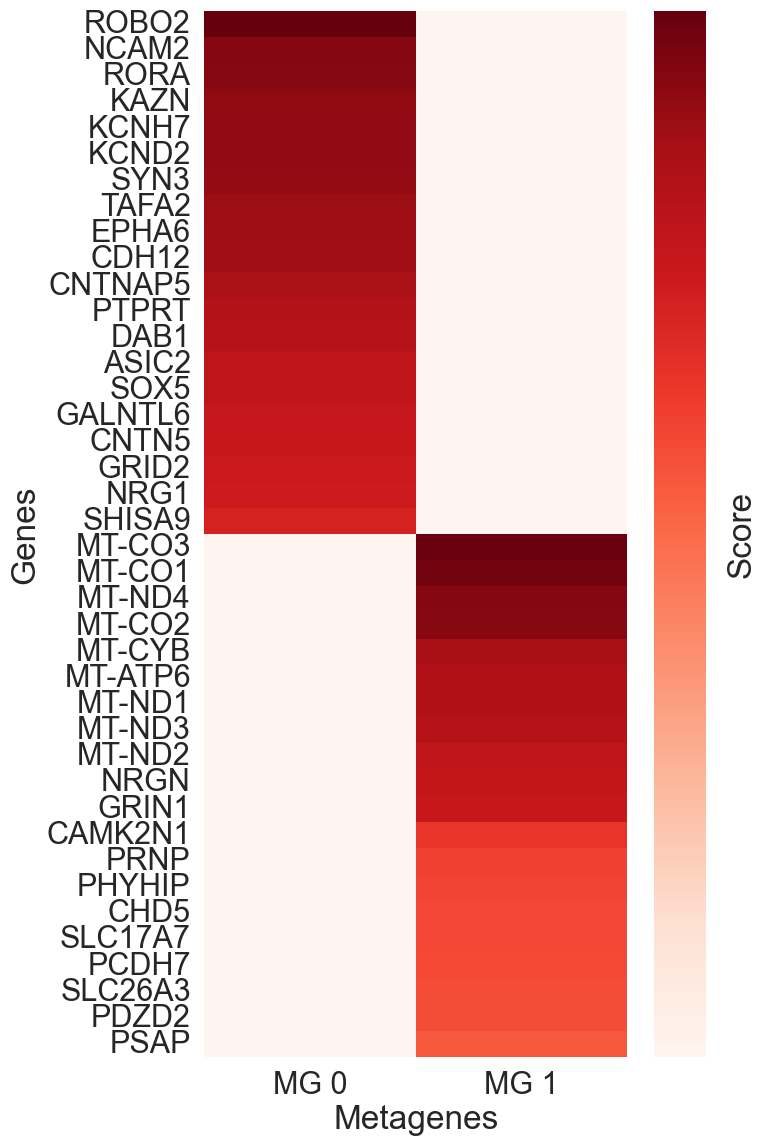

In [19]:
n_top_genes=20
chosen_indeces=[]
for mtg in range(n_metagenes):
    representative_genes_arr = np.argsort(gene_to_metagene[:, mtg])[::-1][:n_top_genes]
    for g in representative_genes_arr:
        if g not in chosen_indeces:
            chosen_indeces.append(g)
gene_labels = np.array(adata.var_names)[chosen_indeces]

plt.figure(figsize=(8,12))
sns.set_context("notebook", font_scale=2)
ax=sns.heatmap(gene_to_metagene[chosen_indeces, :],
                  xticklabels=['MG %s' % i for i in range(n_metagenes)],
                  yticklabels=gene_labels,
                  cmap='Reds',
          )
# Remove colorbar ticks
cbar = ax.collections[0].colorbar
cbar.set_ticks([])  # removes ticks
cbar.set_label('Score', labelpad=15)

plt.xlabel('Metagenes')
plt.ylabel('Genes')
plt.tight_layout()
plt.show()
